# Analysing Global Urban Bus Services using Publicly-Available Routing Data

Authors: [Ed Manley](https://environment.leeds.ac.uk/geography/staff/9293/professor-ed-manley) and [Nick Malleson](http://nickmalleson.co.uk/)

The aim of this work is to analyse public bus transport networks around the world to better understand their importance and impact on society

## Table of Contents

 - [Read Route Metrics Data](#Read-the-Route-Metrics-Data) and [Analysis](#Analysis-of-the-route-city-metrics)
 - [Cluster Analysis](#Cluster-Analysis)
 - The [Implications](#Implications) of the analysis for x


## Initialisation

In [1]:
import os
import pandas as pd
#from sqlalchemy import create_engine
import folium
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
from sklearn import metrics

from IPython.display import Markdown as md # allows markdown printing from python cell

%matplotlib inline
#pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
plt.style.use('seaborn-dark')

## Read the Route Metrics Data

Note that the original data were extracted from XXXX, stored in a local database, and then used to create the CSV files that are read below.

In [2]:
# import data on routes, cities, and subset
route_metrics = pd.read_csv('data/bus_route_metrics.csv')
city_metrics = pd.read_csv('data/city_metrics.csv')

# First subset is all routes except for very short ones. These are used to generat clusters.
subset_cities = []
with open('data/subset_cities.txt') as file:
    for line in file: 
        line = line.strip() 
        subset_cities.append(line)
subset_cities = pd.Series(subset_cities, name='city')
subset_cities = subset_cities.to_frame()

In [3]:
# merge all datasets
route_city_metrics = route_metrics.merge(city_metrics,left_on="location", right_on='city')
route_city_metrics = route_city_metrics.set_index('city').join(subset_cities.set_index('city'), on='city', how='right')
route_city_metrics = route_city_metrics.reset_index(drop=True)

# Extract the name of the city
route_city_metrics['CityName'] = route_city_metrics["city"].apply(lambda x: x.split(',')[0].strip())

In [4]:
len(route_city_metrics)

15130

In [5]:
# filters
route_city_metrics = route_city_metrics[route_city_metrics['route_length'] < 100]
print(len(route_city_metrics))
route_city_metrics = route_city_metrics.loc[(route_city_metrics['sinuocity'] < 50) & (route_city_metrics['sinuocity'] > 1.001)]
print(len(route_city_metrics))

14979
13900


In [6]:
# normalise
# selling point - these measures can be used to describe all bus routes
# connectivity?
# circularity?
route_city_metrics['norm_length'] = route_city_metrics['route_length'].div(route_city_metrics.groupby('location')['route_length'].transform('max'))
route_city_metrics['norm_stops'] = route_city_metrics['route_length'] / route_city_metrics['stops']
route_city_metrics['city_norm_curve'] = route_city_metrics['rel_entropy'] * route_city_metrics['norm_curve']
route_city_metrics['norm_turns'] = route_city_metrics['major_turns'] / route_city_metrics['route_length']

We used data from the following cities and countries:

In [7]:
route_city_metrics['country'] = route_city_metrics['city'].apply(lambda x: x.split(',')[-1].strip() )
countries = route_city_metrics['country']
print("{} countries: {}".format(len(countries.unique()), countries.unique()))

cities = route_city_metrics['city'].apply(lambda x: x.split(',')[0].strip() )
print("{} cities: {}".format(len(cities.unique()), cities.unique()))

19 countries: ['USA' 'Austria' 'Germany' 'Canada' 'Russia' 'Czechia' 'Ireland' 'Spain'
 'Italy' 'Finland' 'Poland' 'Lithuania' 'France' 'Belgium' 'Australia'
 'Latvia' 'New Zealand' 'Mexico' 'Hungary']
95 cities: ['San Francisco' 'Orlando' 'Tucson' 'Denver' 'Boise' 'Vienna' 'New York'
 'Washington' 'Seattle' 'Aachen' 'London' 'Regina' 'St Petersburg'
 'Prague' 'Dublin' 'Bakersfield' 'Eugene' 'Portland' 'Madrid' 'Florence'
 'Helsinki' 'Tampere' 'Warsaw' 'Valencia' 'Los Angeles' 'Turin' 'Bilbao'
 'Kaunas' 'Vilnius' 'El Paso' 'Boston' 'Nancy' 'Toulouse' 'Grenoble'
 'Toronto' 'Rome' 'Palermo' 'Riverside' 'Brussels' 'Oklahoma City'
 'Melbourne VIC' 'Atlanta' 'Raleigh' 'Durham' 'Kansas City' 'Edmonton'
 'Providence' 'Stockton' 'Milan' 'New Orleans' 'Rīga' 'Jacksonville'
 'Hartford' 'Detroit' 'Pittsburgh' 'Saskatoon' 'Philadelphia' 'Calgary'
 'Buffalo' 'Tampa' 'Nashville' 'Columbus' 'Cleveland' 'San Diego'
 'Minneapolis' 'Chicago' 'Sacramento' 'Montreal' 'Auckland' 'Oakland'
 'Queens' 'Bronx'

There is an over-representation of cities in the United States:

In [8]:
print(route_city_metrics.pivot_table(index=['country'], aggfunc='count')['Unnamed: 0'].
      sort_values(axis=0,ascending=False).to_latex())

\begin{tabular}{lr}
\toprule
{} &  Unnamed: 0 \\
country     &             \\
\midrule
USA         &        4601 \\
Australia   &        1980 \\
Canada      &        1789 \\
Italy       &         853 \\
New Zealand &         777 \\
Russia      &         709 \\
Finland     &         575 \\
Hungary     &         365 \\
Poland      &         356 \\
Austria     &         354 \\
Czechia     &         328 \\
Spain       &         282 \\
Lithuania   &         182 \\
France      &         175 \\
Germany     &         172 \\
Mexico      &         119 \\
Ireland     &         106 \\
Belgium     &          95 \\
Latvia      &          82 \\
\bottomrule
\end{tabular}



## Analysis of the route city metrics

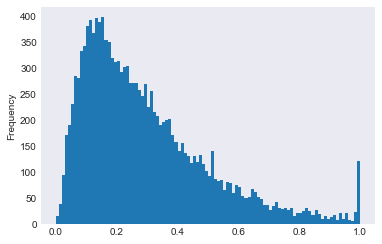

In [9]:
# some plots
route_city_metrics['norm_length'].plot.hist(bins=100);

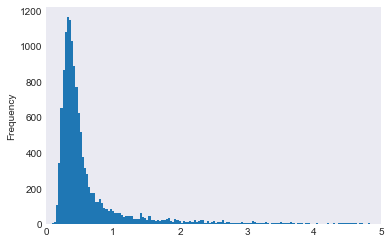

In [10]:
route_city_metrics['norm_stops'].plot.hist(bins=1000, xlim=(0,5));

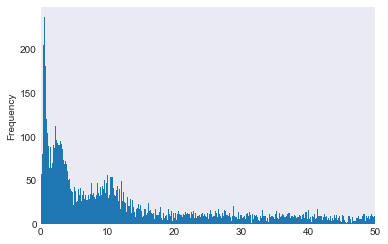

In [11]:
route_city_metrics['city_norm_curve'].loc[route_city_metrics['city_norm_curve'] < 100].plot.hist(bins=1000, xlim=(0,50));

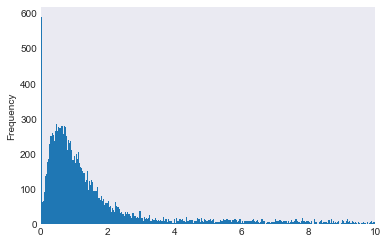

In [12]:
route_city_metrics['norm_turns'].plot.hist(bins=1000, xlim=(0,10));

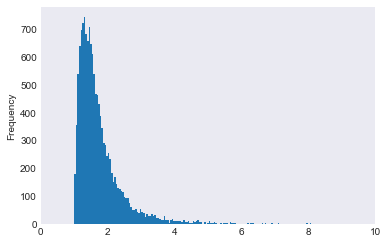

In [13]:
route_city_metrics['sinuocity'].loc[route_city_metrics['sinuocity'] < 100].plot.hist(bins=1000, xlim=(0,10))

## Cluster Analysis

Create clusters of bus routes and cities and analyse them

### Clusters for all Routes

First create Silhouette plots so we know how many clusters to choose

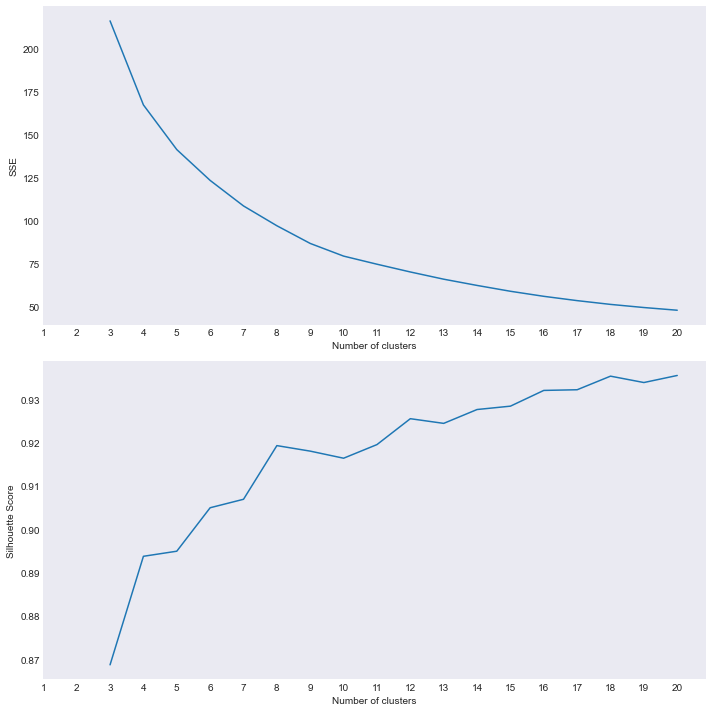

In [14]:
fig = plt.figure(figsize=(10,10))
ss= fig.add_subplot(2,1,1)
si = fig.add_subplot(2,1,2)

n_clusters = 3

sse = {}
sil = {}

while n_clusters <= 20:
    
    # attributes = ['norm_length', 'norm_stops', 'norm_curve', 'sinuocity'] # normalised features
    attributes = ['route_length','norm_stops','sinuocity','city_norm_curve','norm_turns']
    clus_data_raw = route_city_metrics[attributes]

    min_max_scaler = preprocessing.MinMaxScaler()
    np_scaled = min_max_scaler.fit_transform(clus_data_raw)        
    clus_data = pd.DataFrame(np_scaled, columns=attributes)

    clus_data = clus_data.set_index(route_city_metrics.index)

    clusterer = KMeans(n_clusters=n_clusters)
    clusterer.fit(clus_data)

    labels = clusterer.predict(clus_data)    
    clus_data['label'] = labels
    
    sil[n_clusters] = metrics.silhouette_score(clus_data, labels, metric='euclidean')
    sse[n_clusters] = clusterer.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

    n_clusters += 1

ss.plot(list(sse.keys()), list(sse.values()))
si.plot(list(sil.keys()), list(sil.values()))

    
# elbow plot
ss.set_xlabel("Number of clusters")
ss.set_ylabel("SSE")

si.set_xlabel("Number of clusters")
si.set_ylabel("Silhouette Score")

si.set_xticks( range(1, 21))
ss.set_xticks( range(1, 21))
plt.tight_layout()
plt.show()



**IMPORTANT: Decide on the number of clusters**

In [15]:
n_clusters = 7
md("{} clusters are chosen because this is when the Silhouette plot starts to plateau".format(n_clusters))

7 clusters are chosen because this is when the Silhouette plot starts to plateau

Now create the clusters

In [16]:

attributes = ['route_length','norm_stops','sinuocity','city_norm_curve','norm_turns']
clus_data_raw = route_city_metrics[attributes]

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(clus_data_raw)        
clus_data = pd.DataFrame(np_scaled, columns=attributes)

clus_data = clus_data.set_index(route_city_metrics.index)

clusterer = KMeans(n_clusters=n_clusters)
#clusterer = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=2434533)
clusterer.fit(clus_data)

labels = clusterer.predict(clus_data)
        
clus_data['label'] = labels
        
# s_filename = '/Users/edmanley/Dropbox/bus_analysis/global_routes/clusters/all_cities/km_labels_%s_stats.txt' % (n_clusters)
# stats = open(s_filename, 'w')
label_count = 0
while label_count < n_clusters:
    subset = clus_data.loc[clus_data.label == label_count]
    subset = subset[attributes]
    print('CLUSTER ' + str(label_count))
    print(str(subset.describe()))
    
#     stats.write('CLUSTER ' + str(label_count) + '\n')
#     stats.write(str(subset.describe()) + '\n')
#     stats.write('\n')
    label_count += 1
# stats.close()

# fname = '/Users/edmanley/Dropbox/bus_analysis/global_routes/clusters/cities/km_%s_res.txt' % (n_clusters)
# clus_data.to_csv(fname, ',')



CLUSTER 0
       route_length   norm_stops     sinuocity  city_norm_curve   norm_turns
count   4065.000000  4065.000000  4.065000e+03      4065.000000  4065.000000
mean       0.203523     0.025340  1.632490e-02         0.027573     0.028150
std        0.039367     0.038252  1.836049e-02         0.034334     0.022768
min        0.128225     0.003017  3.494170e-07         0.000033     0.000000
25%        0.169427     0.009418  6.431497e-03         0.002750     0.014045
50%        0.198369     0.013412  1.152515e-02         0.012554     0.022753
75%        0.233683     0.023171  1.934063e-02         0.039667     0.035782
max        0.292092     0.397425  2.857605e-01         0.200547     0.171503
CLUSTER 1
       route_length   norm_stops    sinuocity  city_norm_curve   norm_turns
count   1326.000000  1326.000000  1326.000000      1326.000000  1326.000000
mean       0.128280     0.012408     0.019544         0.024775     0.224342
std        0.059542     0.004110     0.018241         0.029

Also look at the average values across all routes; this tells you whether a particular cluster has a higher or lower value for a variable than the mean.

In [17]:
clus_data.describe()

,route_length,norm_stops,sinuocity,city_norm_curve,norm_turns,label
count,13900.000000,13900.000000,13900.000000,13900.000000,13900.000000,13900.000000
mean,0.170690,0.025035,0.018477,0.034382,0.054438,2.434820
std,0.129515,0.048571,0.039753,0.064852,0.069830,1.825268
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.088069,0.008352,0.006469,0.003264,0.015896,0.000000
50%,0.137038,0.011583,0.011600,0.011381,0.029844,3.000000
75%,0.213730,0.019058,0.020119,0.039644,0.056378,4.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000


In [18]:
clus_data.groupby(by='label')['route_length'].count().sort_values()

label
6      39
2     331
5     485
1    1326
3    1419
0    4065
4    6235
Name: route_length, dtype: int64

In [19]:
# cluster summary stats
for i in range(n_clusters):
    print(i,"\n",clus_data[['route_length','norm_stops','city_norm_curve','norm_turns','sinuocity']].
          loc[clus_data['label'] == i].mean())


0 
 route_length       0.203523
norm_stops         0.025340
city_norm_curve    0.027573
norm_turns         0.028150
sinuocity          0.016325
dtype: float64
1 
 route_length       0.128280
norm_stops         0.012408
city_norm_curve    0.024775
norm_turns         0.224342
sinuocity          0.019544
dtype: float64
2 
 route_length       0.698839
norm_stops         0.185793
city_norm_curve    0.017593
norm_turns         0.014023
sinuocity          0.008568
dtype: float64
3 
 route_length       0.369253
norm_stops         0.051686
city_norm_curve    0.027702
norm_turns         0.024204
sinuocity          0.014854
dtype: float64
4 
 route_length       0.088895
norm_stops         0.014057
city_norm_curve    0.023454
norm_turns         0.036864
sinuocity          0.016958
dtype: float64
5 
 route_length       0.127550
norm_stops         0.011198
city_norm_curve    0.287672
norm_turns         0.150870
sinuocity          0.020310
dtype: float64
6 
 route_length       0.096549
norm_stops    

Cluster profiles:

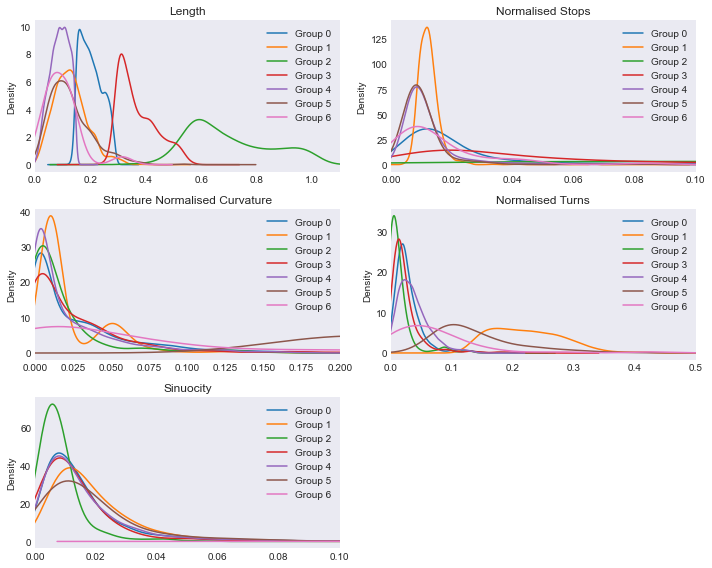

In [20]:
fig = plt.figure(figsize=(10,8))
length= fig.add_subplot(3,2,1)
norm_stops = fig.add_subplot(3,2,2)
city_norm_curve = fig.add_subplot(3,2,3)
norm_turns = fig.add_subplot(3,2,4)
sinuocity = fig.add_subplot(3,2,5)

length.set_title('Length')
norm_stops.set_title('Normalised Stops')
city_norm_curve.set_title('Structure Normalised Curvature')
norm_turns.set_title('Normalised Turns')
sinuocity.set_title('Sinuocity')

#legend = ['Group 0', 'Group 1','Group 2','Group 3','Group 4' ]#,'Group 5'] # 'Group 6', 'Group 7', 'Group 8', 'Group 9']
legend = ['Group '+str(i) for i in range(n_clusters)]

for variable_name, legend_object, _xlim in [('route_length',length,[0,1.1]), ('norm_stops', norm_stops, [0,0.1]), \
                                            ('city_norm_curve', city_norm_curve,[0,0.2]), ('norm_turns',norm_turns,[0,0.5]),\
                                            ('sinuocity',sinuocity,[0,0.1]) ]:
    
    for i in range(n_clusters):
        clus_data[[variable_name]].loc[clus_data['label'] == i].plot.kde(label='Group '+str(i),ax=legend_object)
        
    legend_object.legend(legend)
    legend_object.set_xlim(_xlim)
    


plt.tight_layout()
plt.show()


#fig.savefig(fname="cluster_profiles.pdf", bbox_inches='tight')
#fig.savefig(fname="../abstract/figures/cluster_profiles.pdf", bbox_inches='tight')

In [21]:
# rejoin data with cluster labels
route_city_clusters = pd.concat([clus_data, route_city_metrics], axis=1)

In [22]:
prop_clusters = route_city_clusters.pivot_table(index=['location'], columns=['label'], 
                                                values=['city'], aggfunc='count')
prop_clusters = prop_clusters.fillna(0)
prop_clusters = prop_clusters.div(prop_clusters.sum(1), axis=0)
prop_clusters.head()


city                                                            
label                          0         1         2         3         4         5         6
location                                                                                    
Aachen, Germany         0.244186  0.017442  0.005814  0.069767  0.656977  0.000000  0.005814
Adelaide SA, Australia  0.412162  0.000000  0.000000  0.148649  0.432432  0.003378  0.003378
Atlanta, GA, USA        0.300000  0.000000  0.086667  0.186667  0.406667  0.013333  0.006667
Auckland, New Zealand   0.095101  0.808357  0.002882  0.037464  0.054755  0.000000  0.001441
Austin, TX, USA         0.362745  0.000000  0.019608  0.127451  0.490196  0.000000  0.000000

Make a smaller subset of cities for the bar plot

In [23]:
# First subset is all routes except for very short ones. These are used to generat clusters.
subset_cities2 = []
with open('data/subset_cities2.txt') as file:
    for line in file: 
        line = line.strip() 
        subset_cities2.append(line)
subset_cities2 = pd.Series(subset_cities2, name='city')
subset_cities2 = subset_cities2.to_frame()

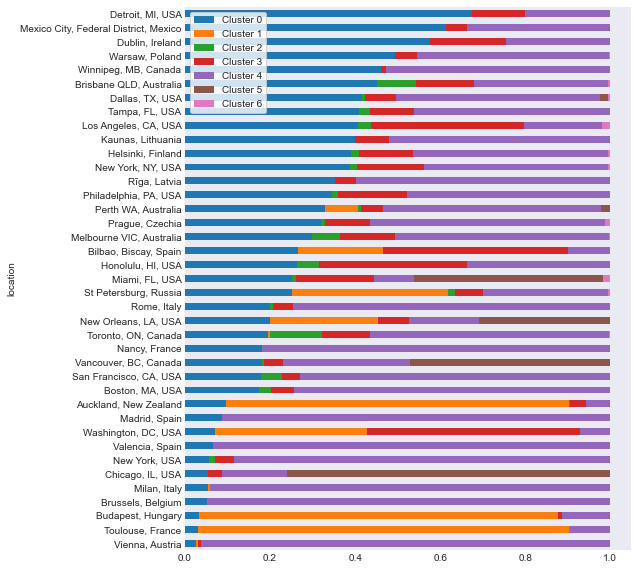

In [24]:
# For all cities:
#prop_clusters.sort_values(by=[('city',0)]).plot(kind='barh', stacked=True, figsize=(15,30), legend=False)

# For the smaller subset:
ax = prop_clusters.loc[subset_cities2['city']].sort_values(by=[('city',0)])\
    .plot(kind='barh', stacked=True, figsize=(8,10), legend=False)

ax.legend( labels=["Cluster {}".format(i) for i in range(n_clusters)], \
          loc="upper left", ncol=1, frameon = True, facecolor="white")

fig = ax.get_figure()

#fig.savefig(fname="barh.pdf", bbox_inches='tight')
#fig.savefig(fname="../abstract/figures/barh.pdf", bbox_inches='tight')

## Implications

What are the implications of this analysis for society? Can we use the analysis here, particularly that of normalised bus route entropy, to provide evidence for the impact that bus routes are having on wider societal outcomes (ranging from satisfaction with public transport to broader quality-of-life indicators). Basically are there any meaninngful relationships between the entropy measures and x.

Possible factors to explore:

 - `[X]` [pollution](#Pollution)
 
 - `[X]` happiness / satisfaction with the bus route: [Moovit](#Satisfaction---Moovit)
 
 - `[X]` [inequality](#Inequality)

 - `[ ]` usage

 - `[ ]` accessibility

 - `[ ]` quality of life, deprivation

 - `[ ]` polycentricity (vs monocebntricity)

 - `[ ]` spending (on public transport) (leads to different types of routes)

 - `[ ]` GDP

Before doing the analysis we need to merge the routes so we have a mean metric for each city

In [34]:
city_metrics = route_city_metrics.groupby('CityName').mean().reset_index()  # ('reset_index' creates the 'CityName')
city_metrics

,CityName,Unnamed: 0,stops,route_length,od_length,sinuocity,time,speed,curve,norm_curve,major_turns,start_lon,start_lat,end_lon,end_lat,entropy,rel_entropy,circuity,avg_degree,intersection_count,norm_length,norm_stops,city_norm_curve,norm_turns
0,Aachen,1397.046512,17.872093,12.846388,7.508852,2.024629,1.0,1.0,5081.759117,434.975441,21.244186,6.249552,50.846963,6.244128,50.842085,3.576403,0.006901,1.077640,4.800668,298167.0,0.193337,0.832021,3.001799,1.884089
1,Adelaide SA,22007.263514,39.081081,17.488053,11.794468,1.700382,1.0,1.0,3087.271453,188.813840,15.621622,138.605775,-34.927856,138.600481,-34.931514,3.321653,0.224469,1.068810,4.795445,55215.0,0.374130,0.527849,42.382765,0.982426
2,Atlanta,20947.146667,40.053333,24.243612,16.937974,1.806094,1.0,1.0,5554.286696,221.155868,16.453333,-84.365309,33.767001,-84.356118,33.769992,3.499400,0.075498,1.099641,4.621076,127686.0,0.307560,1.215976,16.696746,0.825735
3,Auckland,18833.099424,31.115274,16.053570,9.543995,1.894697,1.0,1.0,16861.703378,1076.485336,104.371758,174.777069,-36.862338,174.776799,-36.863269,3.574856,0.008303,1.093581,4.557170,28281.0,0.336577,0.908054,8.937910,6.852951
4,Austin,26221.333333,27.872549,17.550184,10.972799,1.712410,1.0,1.0,3041.982968,193.725136,12.872549,-97.719462,30.306852,-97.731539,30.297752,3.492634,0.081408,1.079638,4.976508,41814.0,0.292863,0.995011,15.770732,0.879718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,Vilnius,5949.000000,20.607477,12.466533,7.484400,1.847346,1.0,1.0,2879.166093,236.269168,7.196262,25.266557,54.699987,25.278965,54.688396,3.561228,0.020613,1.067594,4.818182,7291.0,0.502869,0.646814,4.870190,0.587936
91,Warsaw,4754.050562,27.205056,16.032262,10.288251,1.859648,1.0,1.0,2436.367932,165.604750,9.710674,21.012101,52.229788,21.016691,52.232229,3.564813,0.017382,1.044257,4.834144,40227.0,0.408559,0.643435,2.878578,0.678824
92,Washington,20131.785714,39.214286,27.858113,18.009555,1.687432,1.0,1.0,10618.565558,539.095783,61.214286,-76.970799,38.933292,-77.055837,38.939461,3.562984,0.019032,1.086045,4.786198,97218.0,0.522913,0.920578,10.259857,3.063092
93,Wellington,26404.266667,37.466667,17.272327,8.578242,2.388683,1.0,1.0,17697.501651,1221.826990,120.400000,174.877835,-41.229304,174.855328,-41.237370,3.567842,0.014648,1.113846,4.572124,9654.0,0.190111,0.592182,17.897851,8.382398


Text(0.5, 1.0, 'Mean City Norm Curve by City')

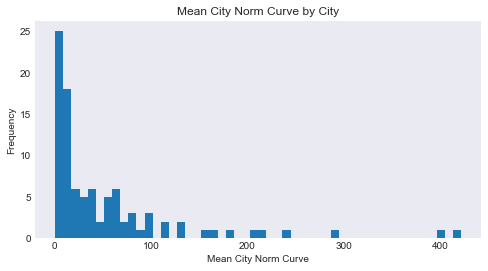

In [43]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.hist(city_metrics['city_norm_curve'], bins=50)
ax.set_xlabel('Mean City Norm Curve')
ax.set_ylabel('Frequency')
ax.set_title('Mean City Norm Curve by City')

### Pollution

The WHO have created the 'Ambient Air Quality Database' in April 2018. Raw Excel data available in [./data/aap_air_quality_database_2018_v14.xlsx](./data/aap_air_quality_database_2018_v14.xlsx). I made a simplified [csv file](./data/aap_air_quality_database_2018_v14.csv).

Read those data, link to the bus route metrics, and see if there are any interesting relationships.

_Is Relative Entropy the best one to use??_

In [26]:
# link to pollution data and do some plots
pollution = pd.read_csv("./data/aap_air_quality_database_2018_v14.csv")

# Join
metrics_pollution = city_metrics.set_index("CityName").join(pollution.set_index("City/Town"), how="inner")
metrics_pollution

,Unnamed: 0,stops,route_length,od_length,sinuocity,time,speed,curve,norm_curve,major_turns,start_lon,start_lat,end_lon,end_lat,entropy,rel_entropy,circuity,avg_degree,intersection_count,norm_length,norm_stops,city_norm_curve,norm_turns,Region,iso3,Country,Year,"Annual mean, ug/m3",Temporal coverage,note on converted PM2.5,Number and type of monitoring stations,Reference for air quality,Database version (year),status
Aachen,1397.046512,17.872093,12.846388,7.508852,2.024629,1.0,1.0,5081.759117,434.975441,21.244186,6.249552,50.846963,6.244128,50.842085,3.576403,0.006901,1.077640,4.800668,298167.0,0.193337,0.832021,3.001799,1.884089,Europe (HIC),DEU,Germany,2015,11,NaN,Measured,2 Urban,The European Environment Agency (EEA),2018,NaN
Atlanta,20947.146667,40.053333,24.243612,16.937974,1.806094,1.0,1.0,5554.286696,221.155868,16.453333,-84.365309,33.767001,-84.356118,33.769992,3.499400,0.075498,1.099641,4.621076,127686.0,0.307560,1.215976,16.696746,0.825735,Americas (HIC),USA,United States of America,2016,11,>75%,Measured,1 Urban And Center City,"US-EPA, Air Quality System (https://www.epa.go...",2018,NaN
Auckland,18833.099424,31.115274,16.053570,9.543995,1.894697,1.0,1.0,16861.703378,1076.485336,104.371758,174.777069,-36.862338,174.776799,-36.863269,3.574856,0.008303,1.093581,4.557170,28281.0,0.336577,0.908054,8.937910,6.852951,Western Pacific (HIC),NZL,New Zealand,2012,6,NaN,Measured,13 stations,Air quality domain report,2016,NaN
Bakersfield,11313.310345,27.586207,43.079834,26.589804,1.864395,1.0,1.0,5296.311064,125.326479,28.172414,-118.900918,35.336869,-118.878197,35.351660,3.200303,0.318659,1.079014,5.197708,167895.0,0.435920,3.056595,39.936430,0.723823,Americas (HIC),USA,United States of America,2014,18,50% -< 75%,Measured,1 Urban And Center City,"US-EPA, Air Quality System (https://www.epa.go...",2018,NaN
Boston,20452.551402,31.532710,13.206040,9.152264,1.581222,1.0,1.0,2157.983372,198.964911,7.271028,-71.080573,42.360954,-71.066756,42.355413,3.574047,0.009036,1.087887,5.069685,194951.0,0.153640,0.703152,1.797819,0.733807,Americas (HIC),USA,United States of America,2016,7,50% -< 75%,Measured,3 Urban And Center City,"US-EPA, Air Quality System (https://www.epa.go...",2018,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Valencia,4950.000000,22.935484,8.428286,5.354698,1.704428,1.0,1.0,2856.613198,355.894577,3.677419,-0.379005,39.470898,-0.366535,39.458552,3.506520,0.069257,1.050165,3.918768,15471.0,0.318689,0.364771,24.648355,0.509501,Europe (HIC),ESP,Spain,2016,10,>75%,Measured,"3 Rural-Background, 2 Urban-Background, 2 Urba...",The European Environmental Agency (EEA) [downl...,2018,NaN
Vancouver,25412.500000,29.045000,13.165999,7.893069,2.138417,1.0,1.0,4124.783071,359.833639,28.425000,-122.935672,49.206703,-122.888980,49.218452,2.929942,0.506592,1.064354,5.014498,38476.0,0.194281,0.570768,182.288694,2.508229,Americas (HIC),CAN,Canada,2013,7,NaN,Measured,-,National Air Pollution Surveillance Network.,2016,NaN
Vilnius,5949.000000,20.607477,12.466533,7.484400,1.847346,1.0,1.0,2879.166093,236.269168,7.196262,25.266557,54.699987,25.278965,54.688396,3.561228,0.020613,1.067594,4.818182,7291.0,0.502869,0.646814,4.870190,0.587936,Europe (HIC),LTU,Lithuania,2016,20,>75%,Measured,"2 Urban-Background, 1 Urban-Industrial, 1 Urba...",The European Environmental Agency (EEA) [downl...,2018,Under revision
Washington,20131.785714,39.214286,27.858113,18.009555,1.687432,1.0,1.0,10618.565558,539.095783,61.214286,-76.970799,38.933292,-77.055837,38.939461,3.562984,0.019032,1.086045,4.786198,97218.0,0.522913,0.920578,10.259857,3.063092,Americas (HIC),USA,United States of America,2016,7,>75%,Measured,1 Suburban,"US-EPA, Air Quality System (https://www.epa.go...",2018,NaN


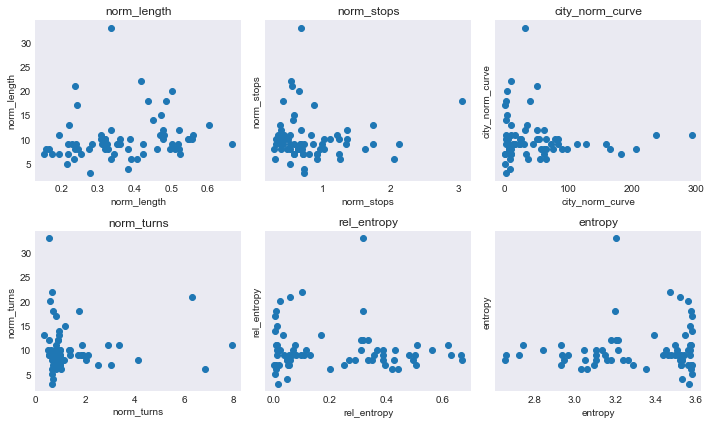

In [45]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=True, figsize=(10,6))

for i, var in enumerate(['norm_length', 'norm_stops', 'city_norm_curve', 'norm_turns', 'rel_entropy', 'entropy']):
    ax = axes.flatten()[i]
    ax.scatter(x=metrics_pollution[var], y=metrics_pollution['Annual mean, ug/m3']) 
    ax.set_xlabel(var)
    ax.set_ylabel(var)
    ax.set_title(var)

fig.tight_layout()

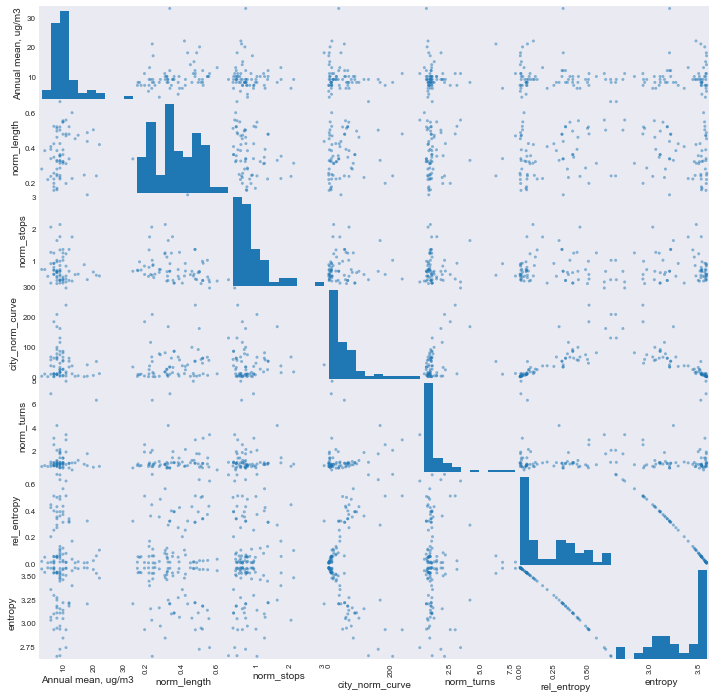

In [52]:

features = ['Annual mean, ug/m3', 'norm_length', 'norm_stops', 'city_norm_curve', 'norm_turns', 'rel_entropy', 'entropy', ] 
   
# plotting the scatter matrix 
# with the features 
pd.plotting.scatter_matrix(metrics_pollution[features], figsize=(12,12)) 
plt.show() 

### Satisfaction - Moovit

Use the _Moovit Global Public Transport Report 2019_ [link](https://company.moovit.com/global-transport-report/) and look for correlations between satisfaction and the network factors previously calculated.

#### Read Moovit data

Although released publicly, the data were not available for a direct download so were copied from the website. They're in a weird format so deal with that first

In [28]:
header = ["Country",
          "City",
          "Transit1", #"Closer transit stations to my home/work to reduce my walking distance",
          "Transit2", #"A way to get to the station from my home (using shuttle, micro-mobility)",
          "Accurate and reliable arrival times according to the published schedule",
          "Better accessibility for people with needs (wheelchair, ramps, etc.)",
          "Cleanliness - Cleaner buses/trains and stations",
          "Comfort - Wider seats, access to WiFi, air-conditioning, charging outlets",
          "Convenient parking areas near stations for car owners",
          "Convenient ways to purchase transit tickets (mobile ticketing)",
          "Higher frequency of public transit vehicles/shorter waiting times at stations",
          "Less transfers - Having more direct lines to my destination",
          "Lower cost fares",
          "Personal safety - Feeling safer when riding public transit.",
          "Shorter trip duration time (less congestion)",
          "Uncrowded - Vehicles that are not overly packed"]

with open("./data/moovit_survey_raw.csv") as f:
    # The file is one long column so need to read over it and organise into a table
    count = 0 # keep a count so we know when we have reaached a new row
    table = [] # each item in this array will be a row (another array)
    row = []
    for line in f:
        line = line.strip().replace('%','') # Gets rid of percent signs
        if line =="": # Ignore blank lines
            continue
        if count == len(header): # Have read a whole row. Restart
            count = 0
            table.append(row)
            #print(row)
            row = []
        # Have a data item. If it can be converted, make it a number
        try:
            number = float(line)
            row.append(number)
        except ValueError:
            row.append(line) # Not a number. Probably a city/country name
        count += 1

moovit = pd.DataFrame(table, columns=header)
moovit

,Country,City,Transit1,Transit2,Accurate and reliable arrival times according to the published schedule,"Better accessibility for people with needs (wheelchair, ramps, etc.)",Cleanliness - Cleaner buses/trains and stations,"Comfort - Wider seats, access to WiFi, air-conditioning, charging outlets",Convenient parking areas near stations for car owners,Convenient ways to purchase transit tickets (mobile ticketing),Higher frequency of public transit vehicles/shorter waiting times at stations,Less transfers - Having more direct lines to my destination,Lower cost fares,Personal safety - Feeling safer when riding public transit.,Shorter trip duration time (less congestion),Uncrowded - Vehicles that are not overly packed
0,﻿France,Paris,25.1,13.5,42.7,13.2,28.7,25.4,13.1,13.4,37.6,29.5,27.9,27.9,38.6,18.8
1,Canada,Toronto,25.3,17.3,46.8,17.0,25.1,31.0,13.6,17.7,51.2,28.4,44.9,23.5,40.2,35.8
2,France,Nice & Cannes,25.8,13.8,48.0,8.0,17.2,20.4,10.7,13.1,41.2,30.8,23.1,19.3,34.0,20.2
3,France,Marseille & Provence,25.8,14.9,45.4,11.1,18.2,22.2,10.9,20.6,34.8,28.1,29.3,18.0,40.0,17.0
4,USA,Los Angeles,25.9,17.6,38.8,13.4,30.0,29.9,10.7,19.2,43.9,25.1,33.1,32.9,35.2,25.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,Colombia,Cali,15.9,11.2,60.5,13.8,24.2,26.7,7.0,32.3,72.5,37.3,27.2,35.4,41.4,51.1
90,Spain,Zaragoza,16.2,10.4,27.1,10.4,12.3,23.4,6.7,15.4,53.5,22.5,26.4,13.2,26.6,32.9
91,Italy,Firenze,16.3,8.9,43.7,7.2,18.3,16.5,11.9,8.3,49.5,24.5,29.3,15.8,32.4,37.5
92,México,Puebla,16.4,12.0,48.8,12.6,37.1,21.9,4.7,12.0,50.6,30.7,38.0,55.8,37.4,50.0


In [29]:
# join to the metrics data
metrics_moovit = city_metrics.set_index("CityName").join(moovit.set_index("City"), how="inner")

metrics_moovit

,Unnamed: 0,stops,route_length,od_length,sinuocity,time,speed,curve,norm_curve,major_turns,start_lon,start_lat,end_lon,end_lat,entropy,rel_entropy,circuity,avg_degree,intersection_count,norm_length,norm_stops,city_norm_curve,norm_turns,Country,Transit1,Transit2,Accurate and reliable arrival times according to the published schedule,"Better accessibility for people with needs (wheelchair, ramps, etc.)",Cleanliness - Cleaner buses/trains and stations,"Comfort - Wider seats, access to WiFi, air-conditioning, charging outlets",Convenient parking areas near stations for car owners,Convenient ways to purchase transit tickets (mobile ticketing),Higher frequency of public transit vehicles/shorter waiting times at stations,Less transfers - Having more direct lines to my destination,Lower cost fares,Personal safety - Feeling safer when riding public transit.,Shorter trip duration time (less congestion),Uncrowded - Vehicles that are not overly packed
Bilbao,5567.500000,18.300000,26.314517,14.581068,1.867961,1.0,1.0,18993.597423,791.967072,73.866667,-2.983995,43.298218,-2.950249,43.291164,3.580102,0.003544,1.197859,4.249279,24084.0,0.496898,1.989703,2.806863,3.185352,Spain,20.7,11.1,26.9,10.3,7.0,21.2,12.9,15.9,44.1,18.6,34.5,14.8,25.5,16.8
Boston,20452.551402,31.532710,13.206040,9.152264,1.581222,1.0,1.0,2157.983372,198.964911,7.271028,-71.080573,42.360954,-71.066756,42.355413,3.574047,0.009036,1.087887,5.069685,194951.0,0.153640,0.703152,1.797819,0.733807,USA,22.6,14.5,43.4,11.1,18.9,24.9,12.8,22.6,43.1,17.5,33.7,18.2,31.0,31.0
Chicago,17878.554348,50.586957,13.519627,10.622363,1.346284,1.0,1.0,9905.268629,739.376053,88.076087,-87.678205,41.863313,-87.684258,41.860480,2.865393,0.546986,1.064900,5.361776,178117.0,0.302402,0.334955,404.428172,6.666457,USA,22.7,13.2,41.4,14.8,34.0,28.5,8.5,12.3,41.4,20.0,26.8,36.2,30.7,26.8
Los Angeles,16033.209877,54.308642,26.951967,18.729154,2.241488,1.0,1.0,2415.328843,103.237413,11.253086,-118.320633,34.037832,-118.288661,34.062557,3.201599,0.317686,1.075040,5.099048,283035.0,0.335344,0.671764,32.797034,0.525628,USA,25.9,17.6,38.8,13.4,30.0,29.9,10.7,19.2,43.9,25.1,33.1,32.9,35.2,25.9
Madrid,16005.769231,25.665158,9.133998,5.664786,1.729776,1.0,1.0,2272.253085,260.546638,11.547511,-3.688344,40.425138,-3.676903,40.426633,3.571389,0.011442,1.053427,4.024237,59563.0,0.387636,0.435762,2.981290,1.366146,Spain,23.2,13.7,39.1,14.2,13.1,24.0,11.4,20.7,59.8,33.3,29.5,18.5,38.4,33.6
Miami,24020.747826,48.556522,21.220738,14.345755,2.125321,1.0,1.0,6260.776272,308.240287,40.947826,-80.279362,25.809862,-80.249801,25.775723,2.649574,0.669519,1.071732,5.289405,81069.0,0.237137,1.013712,206.372808,2.032850,USA,17.9,17.1,32.9,11.5,20.9,26.1,10.3,17.9,35.9,19.2,22.2,17.9,32.5,13.2
Montreal,22253.801047,32.882199,15.910933,10.448112,1.988266,1.0,1.0,1873.834133,149.641512,8.727749,-73.619595,45.541801,-73.629027,45.541321,3.533021,0.045849,1.108434,5.209106,98840.0,0.165730,0.965413,6.860946,0.697286,Canada,18.2,9.7,34.8,10.5,13.0,22.7,11.7,15.8,45.7,22.7,32.8,10.5,32.8,36.0
Philadelphia,13385.485915,57.478873,18.566355,12.548784,1.567787,1.0,1.0,2633.886461,146.184250,9.492958,-75.192768,40.012639,-75.200038,40.006454,3.543550,0.036467,1.079850,5.164573,132623.0,0.322780,0.520210,5.330926,0.547645,USA,18.0,14.4,41.7,11.5,33.8,27.0,8.7,17.5,39.2,19.2,39.4,27.0,30.4,31.8
Pittsburgh,13080.500000,56.690909,18.390882,10.757022,2.228233,1.0,1.0,3392.811397,202.771956,13.654545,-79.983215,40.439398,-79.962977,40.438350,3.572420,0.010509,1.093358,5.052690,39938.0,0.325548,0.383046,2.130890,0.893628,USA,19.5,12.7,43.8,11.2,26.2,34.1,13.9,23.2,40.1,18.7,30.0,16.1,29.2,29.6
Toronto,25074.191882,35.845018,21.766032,15.954394,1.661574,1.0,1.0,3898.305032,188.415719,17.594096,-79.446131,43.725050,-79.404239,43.706634,3.438969,0.127612,1.084415,5.326199,129465.0,0.219433,1.336512,24.044168,0.837829,Canada,25.3,17.3,46.8,17.0,25.1,31.0,13.6,17.7,51.2,28.4,44.9,23.5,40.2,35.8


#### Moovit - Entropy analysis

Look for relationship between satisfaction (from Moovit data) and relative entropy (_should this be entropy difference?_)

Text(0.5, 0.98, 'Transit1 (closer stations to reduce walking distance')

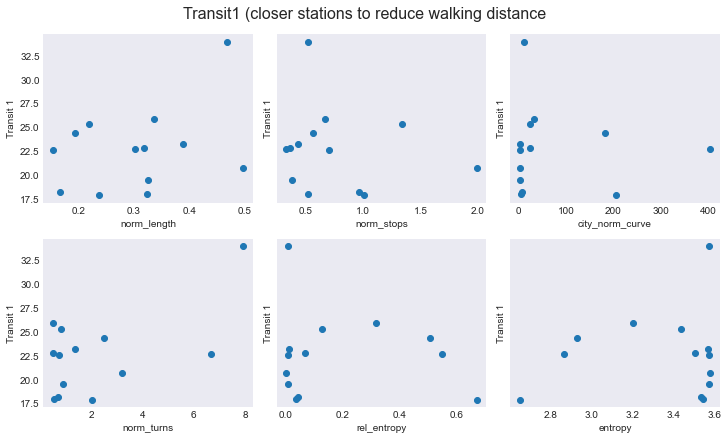

In [30]:


fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=True, figsize=(10,6), constrained_layout=True)

for i, var in enumerate(['norm_length', 'norm_stops', 'city_norm_curve', 'norm_turns', 'rel_entropy', 'entropy']):
    ax = axes.flatten()[i]
    ax.scatter(x=metrics_moovit[var], y=metrics_moovit['Transit1']) 
    ax.set_xlabel(var)
    ax.set_ylabel("Transit 1")
    #ax.set_title(var)

fig.suptitle("Transit1 (closer stations to reduce walking distance", fontsize=16)


Text(0.5, 0.98, 'Transit2 (a way to get to the station from my house)')

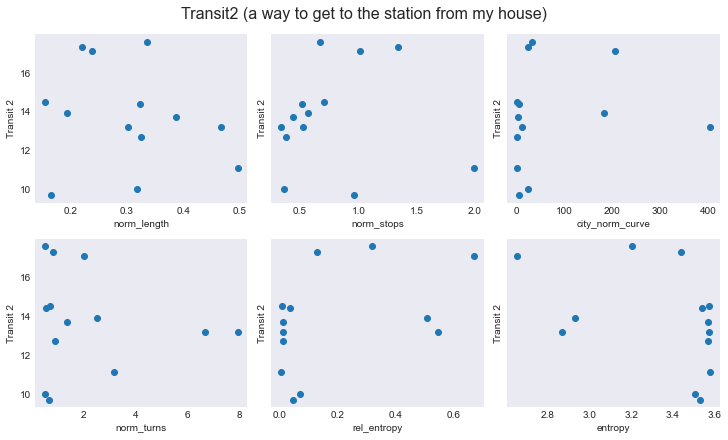

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=True, figsize=(10,6), constrained_layout=True)

for i, var in enumerate(['norm_length', 'norm_stops', 'city_norm_curve', 'norm_turns', 'rel_entropy', 'entropy']):
    ax = axes.flatten()[i]
    ax.scatter(x=metrics_moovit[var], y=metrics_moovit['Transit2']) 
    ax.set_xlabel(var)
    ax.set_ylabel("Transit 2")
    #ax.set_title(var)

fig.suptitle("Transit2 (a way to get to the station from my house)", fontsize=16)


### Inequality

Can get Gini measures by country but not city.

Could focus on American cities using the 2019 American Community Survey. E.g. see [blog post](https://www.usnews.com/news/cities/articles/2020-09-21/us-cities-with-the-biggest-income-inequality-gaps) or [dashboard (with data)](https://apps.urban.org/features/inclusion/index.html)

Or on British cities  https://doi.org/10.1080/00343404.2015.1053859  


#### Inequality in American cities

 - Data: [Measuring Inclusion in America’s Cities](https://apps.urban.org/features/inclusion/data/measuring-inclusion-data.xlsx)
 - Explanation: [website](https://apps.urban.org/features/inclusion/index.html?topic=map)
 
Get data for the following variables (`column`: name of variable, type, (obreviation)): 
 - `GP`: Unemployment Rate (2016), Z-Score, (UnemRateZScore)
 - `GX`: Income Segregation (2016), Z-Score, (IncSegZScore)
 - `IB`: Racial Inclusion Index (2016), Score, (RacialIncIndex)
 - `HZ`: Overall Inclusion Index (2016), Score (OverallIncIndex)

In [32]:
ineq_vars = ['UnemRateZScore', 'IncSegZScore', 'RacialIncIndex', 'OverallIncIndex']  # The columns to create

us_ineq = pd.read_excel(os.path.join("data", "measuring-inclusion-data.xlsx"),
                        sheet_name="Data",
                        header=None,
                        names=["Place", "State"]+ineq_vars,
                        usecols="A:B,GP,GX,IB,HZ",
                        skiprows=2,
                       )
us_ineq


,Place,State,UnemRateZScore,IncSegZScore,RacialIncIndex,OverallIncIndex
0,Fremont,CA,1.062462,1.071146,1.645690,1.618869
1,Sunnyvale,CA,0.892115,1.531122,0.933453,1.295710
2,Bellevue,WA,1.111795,1.333674,0.909129,1.295164
3,Santa Clara,CA,1.175799,1.306914,1.319335,1.253890
4,Daly City,CA,0.411440,1.516051,1.460754,1.200545
...,...,...,...,...,...,...
269,Springfield,IL,-0.278841,-1.388418,-1.050147,-0.878673
270,South Bend,IN,-0.264509,-0.488349,-0.933147,-0.892028
271,Dallas,TX,0.630302,-2.073523,-0.657146,-0.938628
272,Houston,TX,0.248587,-1.553724,-0.890138,-0.982792


Have a look at how well correlated the different inequality meausres are correlated. Some not strong correlation so worth plotting a few against bus route metrics

In [33]:
us_ineq.loc[:, ineq_vars].corr()

,UnemRateZScore,IncSegZScore,RacialIncIndex,OverallIncIndex
UnemRateZScore,1.000000,0.011927,-0.065760,0.253345
IncSegZScore,0.011927,1.000000,0.553361,0.619614
RacialIncIndex,-0.065760,0.553361,1.000000,0.847743
OverallIncIndex,0.253345,0.619614,0.847743,1.000000


In [108]:
# Link inqeuality data to the bus data
metrics_ineq = city_metrics.set_index("CityName").join(us_ineq.set_index("Place"), how="inner")
metrics_ineq

,Unnamed: 0,stops,route_length,od_length,sinuocity,time,speed,curve,norm_curve,major_turns,start_lon,start_lat,end_lon,end_lat,entropy,rel_entropy,circuity,avg_degree,intersection_count,norm_length,norm_stops,city_norm_curve,norm_turns,State,UnemRateZScore,IncSegZScore,RacialIncIndex,OverallIncIndex
Atlanta,20947.146667,40.053333,24.243612,16.937974,1.806094,1.0,1.0,5554.286696,221.155868,16.453333,-84.365309,33.767001,-84.356118,33.769992,3.499400,0.075498,1.099641,4.621076,127686.0,0.307560,1.215976,16.696746,0.825735,GA,-0.361725,-3.691981,-0.890777,-0.807250
Austin,26221.333333,27.872549,17.550184,10.972799,1.712410,1.0,1.0,3041.982968,193.725136,12.872549,-97.719462,30.306852,-97.731539,30.297752,3.492634,0.081408,1.079638,4.976508,41814.0,0.292863,0.995011,15.770732,0.879718,TX,1.118822,-1.556600,-0.095407,-0.150429
Bakersfield,11313.310345,27.586207,43.079834,26.589804,1.864395,1.0,1.0,5296.311064,125.326479,28.172414,-118.900918,35.336869,-118.878197,35.351660,3.200303,0.318659,1.079014,5.197708,167895.0,0.435920,3.056595,39.936430,0.723823,CA,-0.772420,-1.025506,-0.073467,-0.124087
Boston,20452.551402,31.532710,13.206040,9.152264,1.581222,1.0,1.0,2157.983372,198.964911,7.271028,-71.080573,42.360954,-71.066756,42.355413,3.574047,0.009036,1.087887,5.069685,194951.0,0.153640,0.703152,1.797819,0.733807,MA,-0.185429,-0.971398,-0.430225,-0.106447
Buffalo,15290.000000,42.142857,22.796084,14.902126,1.744486,1.0,1.0,16057.013920,923.539508,100.142857,-78.841792,42.883335,-78.875433,42.935759,3.006343,0.456551,1.058187,5.449005,26700.0,0.420636,0.609044,421.643330,6.044859,NY,-0.337742,-0.344964,-0.622031,-0.617386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Stockton,11620.820513,18.384615,17.987352,10.388132,1.820964,1.0,1.0,2933.057101,217.096321,12.076923,-121.316354,37.935735,-121.304795,37.965379,3.391643,0.167370,1.093951,4.939645,77112.0,0.222020,1.741866,36.335419,0.958591,CA,-1.366405,-0.274663,0.366486,0.031256
Tampa,15313.564103,33.282051,17.234638,11.459565,1.498203,1.0,1.0,2197.748908,141.951112,12.025641,-82.444467,27.947561,-82.446933,27.970119,2.841572,0.561457,1.107636,5.065596,35990.0,0.309570,1.243800,79.699437,0.802835,FL,-0.229627,-2.048724,-0.329095,-0.497381
Tucson,7604.000000,31.488889,19.538567,12.882561,1.599868,1.0,1.0,2323.868727,133.918612,14.511111,-110.956891,32.206822,-110.974348,32.249269,3.060100,0.419894,1.078109,5.005492,33910.0,0.390144,1.261603,56.231655,0.845063,AZ,-0.630519,-0.087612,0.116006,-0.230492
Vancouver,25412.500000,29.045000,13.165999,7.893069,2.138417,1.0,1.0,4124.783071,359.833639,28.425000,-122.935672,49.206703,-122.888980,49.218452,2.929942,0.506592,1.064354,5.014498,38476.0,0.194281,0.570768,182.288694,2.508229,WA,0.300124,0.879513,0.376534,0.405408


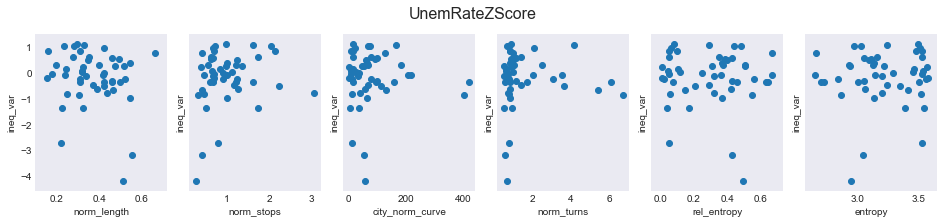

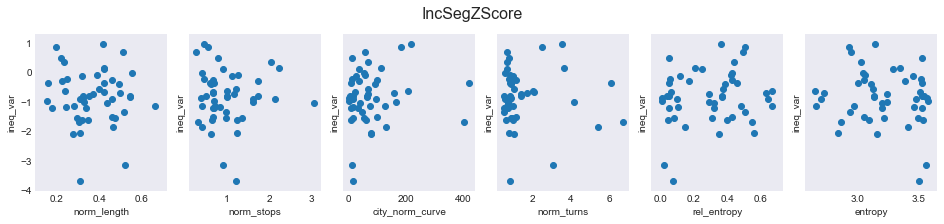

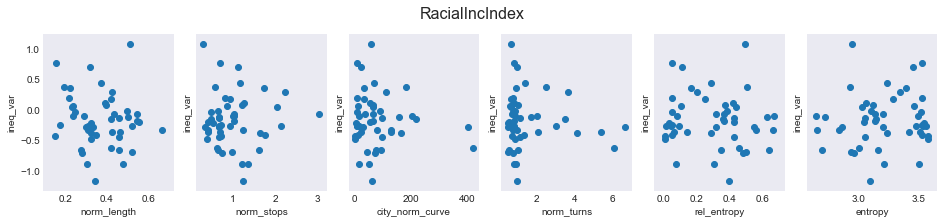

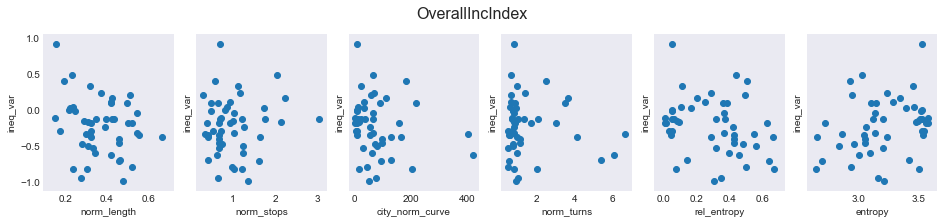

In [119]:

for ineq_var in ineq_vars:
    fig, axes = plt.subplots(nrows=1, ncols=6, sharex=False, sharey=True, figsize=(13,3), constrained_layout=True)
    for i, var in enumerate(['norm_length', 'norm_stops', 'city_norm_curve', 'norm_turns', 'rel_entropy', 'entropy']):
        ax = axes.flatten()[i]
        ax.scatter(x=metrics_ineq[var], y=metrics_ineq[ineq_var]) 
        ax.set_xlabel(var)
        ax.set_ylabel("ineq_var")
        #ax.set_title(var)

    fig.suptitle(ineq_var, fontsize=16)
